In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import bayesflow as bf
import numpy as np
import matplotlib.pyplot as plt

# Simple example

## Simulator

In [2]:
def context(batch_size, n=None):
    if n is None:
        n = np.random.randint(10, 101)

    return dict(n=n)

def prior(mu=None, sigma=None):
    if mu is None:
        mu = np.random.normal()
    if sigma is None:
        sigma = np.random.gamma(shape=2)

    return dict(mu=mu, sigma=sigma)

def likelihood(n, mu, sigma):
    y = np.random.normal(mu, sigma, size=n)

    return dict(y=y)

def summary(y):
    mean = np.mean(y)
    sd = np.std(y, ddof=1)
    
    return dict(mean=mean, sd=sd)

In [3]:
simulator = bf.make_simulator([prior, likelihood, summary], meta_fn=context)

### Prior predictives

In [4]:
data = simulator.sample(1000)

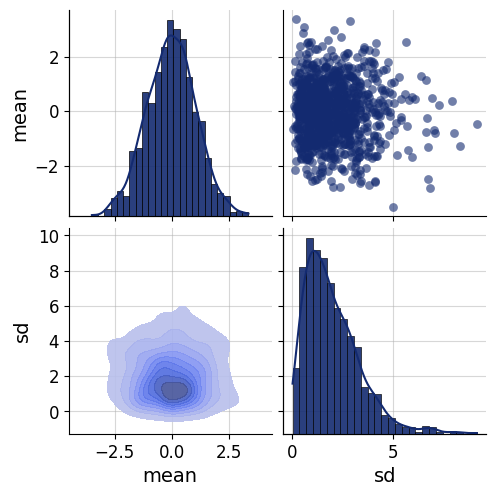

In [5]:
fig=bf.diagnostics.pairs_samples(data, variable_keys=["mean", "sd"])

## Approximator

In [6]:
adapter = (bf.Adapter()
    .broadcast("n", to="mean")
    .constrain("sigma", lower=0)
    .concatenate(["n", "mean", "sd"], into="inference_conditions")
    .concatenate(["mu", "sigma"], into="inference_variables")
    .drop("y")
    )

In [7]:
adapter(data)

{'inference_conditions': array([[40.        ,  1.14834128,  3.1105106 ],
        [40.        ,  0.13910936,  3.11815168],
        [40.        , -1.10680061,  3.2639641 ],
        ...,
        [40.        , -1.73994389,  2.28913783],
        [40.        ,  0.80585333,  1.42037749],
        [40.        ,  1.18997696,  0.6292014 ]]),
 'inference_variables': array([[ 1.2641924 ,  2.715853  ],
        [-1.01831639,  3.1689373 ],
        [-0.45304487,  3.04768361],
        ...,
        [-1.43358309,  2.04178001],
        [ 0.5870799 ,  0.91035713],
        [ 1.16655367, -0.21248415]])}

In [8]:
approximator = bf.approximators.ContinuousApproximator(
    inference_network=bf.networks.CouplingFlow(permutation="swap", subnet_kwargs=dict(dropout=False)),
    adapter=adapter
)

In [9]:
epochs=10
num_batches=100
batch_size=256

In [10]:
schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=epochs * num_batches)
optimizer = keras.optimizers.Adam(learning_rate=schedule)

In [11]:
approximator.compile(optimizer)

In [12]:
history=approximator.fit(
    epochs=epochs,
    num_batches=num_batches,
    batch_size=batch_size,
    simulator=simulator)

INFO:bayesflow:Building dataset from simulator instance of SequentialSimulator.
INFO:bayesflow:Using 10 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 3.4689 - loss/inference_loss: 3.4689
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.4439 - loss/inference_loss: 2.4439
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.5144 - loss/inference_loss: 1.5144
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.3702 - loss/inference_loss: 1.3702
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.9980 - loss/inference_loss: 0.9980
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5172 - loss/inference_loss: 0.5172
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3742 - loss/inference_loss: 0.3742
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0789 - loss/inference_loss: 0.0789
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1717 - loss/inference_loss: 0.1717
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1194 - loss/inference_loss: 0.1194


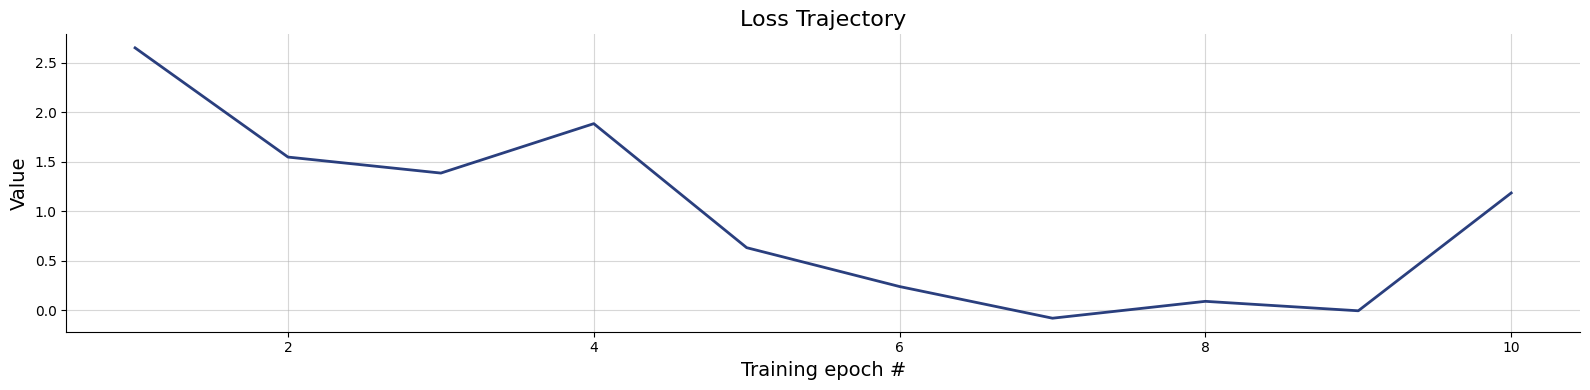

In [13]:
fig=bf.diagnostics.plots.loss(history)

## Validation

In [14]:
test_data = simulator.sample(1000, n=50)
prior = dict(mu=test_data["mu"], sigma=test_data["sigma"])
posterior = approximator.sample(num_samples=500, conditions=test_data)

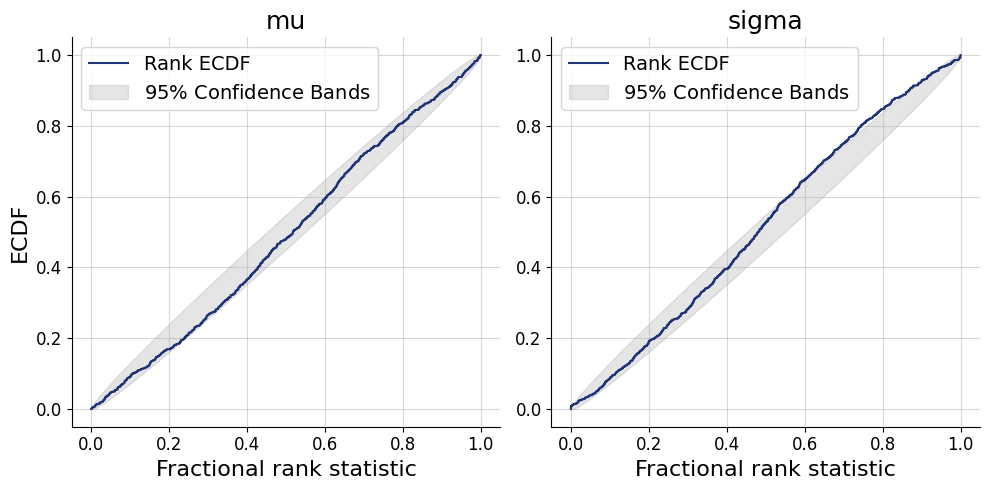

In [15]:
fig=bf.diagnostics.plots.calibration_ecdf(estimates=posterior, targets=prior)

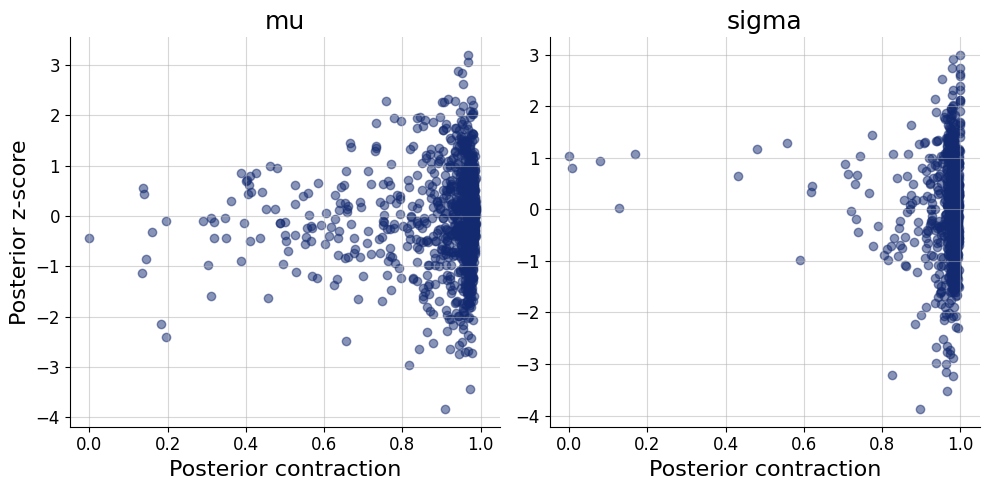

In [16]:
fig=bf.diagnostics.z_score_contraction(estimates=posterior, targets=prior)

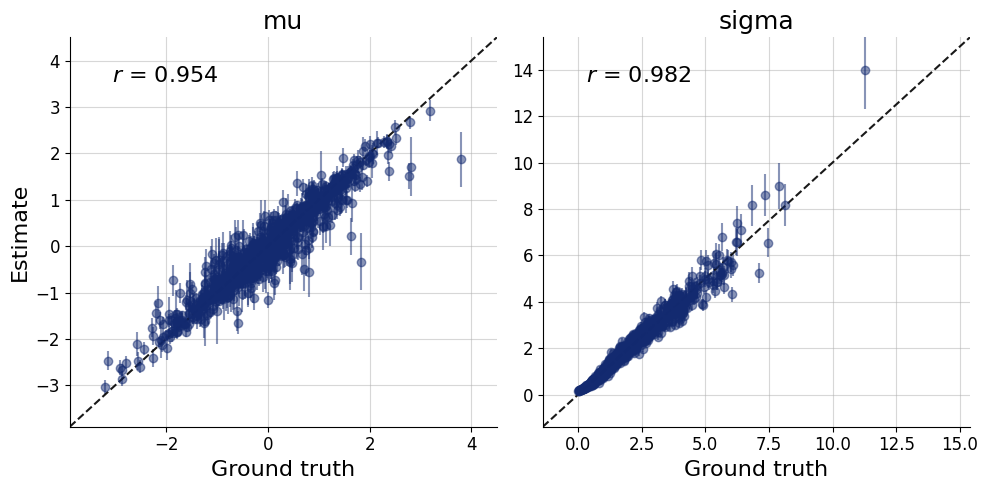

In [17]:
fig=bf.diagnostics.plots.recovery(estimates=posterior, targets=prior)

## Inference

In [18]:
inference_data = dict(n=50, mean=np.array([[0.5]]), sd=np.array([[2]]))

In [19]:
posterior = approximator.sample(num_samples=1000, conditions=inference_data)

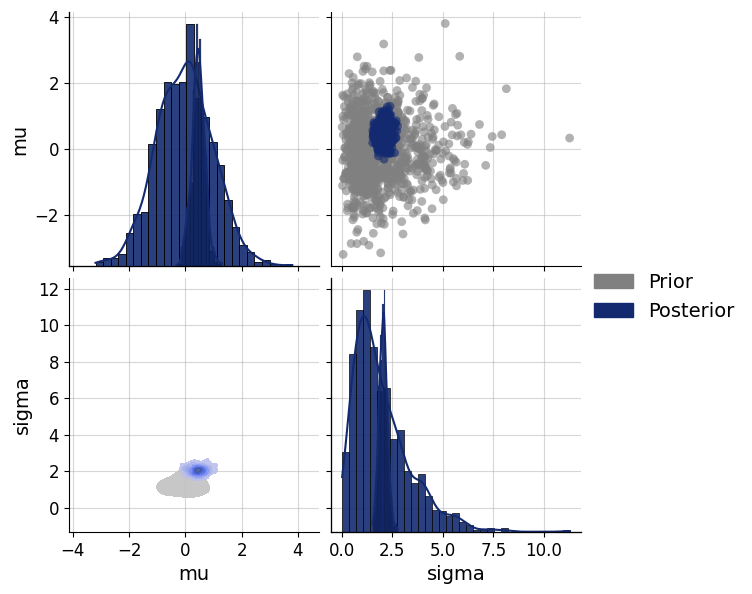

In [20]:
fig=bf.diagnostics.pairs_posterior(estimates=posterior, priors=prior)

# Using summary network

## Approximator

In [21]:
adapter = (bf.Adapter()
    .broadcast("n", to="y")
    .as_set("y")
    .constrain("sigma", lower=0)
    .rename("n", "inference_conditions")
    .rename("y", "summary_variables")
    .concatenate(["mu", "sigma"], into="inference_variables")
    .drop(["mean", "sd"])
    )

In [22]:
workflow = bf.BasicWorkflow(
    inference_network=bf.networks.CouplingFlow(subnet_kwargs=dict(dropout=False)), 
    summary_network=bf.networks.DeepSet(
        base_distribution="normal",
        dropout=False,
        mlp_widths_equivariant=(16, 16), 
        mlp_widths_invariant_inner=(16, 16),
        mlp_widths_invariant_outer=(16, 16),
        mlp_widths_invariant_last=(16, 16)
        ),
    simulator=simulator,
    adapter=adapter,
    inference_variables=["mu", "sigma"],
    inference_conditions="n",
    summary_variables="y"
)

In [23]:
history=workflow.fit_online(epochs=epochs, num_batches_per_epoch=num_batches, batch_size=batch_size)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 3.2052 - loss/inference_loss: 2.7499 - loss/summary_loss: 0.4553
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 1.7881 - loss/inference_loss: 1.5033 - loss/summary_loss: 0.2848
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.9579 - loss/inference_loss: 0.7278 - loss/summary_loss: 0.2301
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.7740 - loss/inference_loss: 0.5643 - loss/summary_loss: 0.2098
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.5151 - loss/inference_loss: 0.3133 - loss/summary_loss: 0.2018
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.4264 - loss/inference_loss: 0.2281 - loss/summary_loss: 0.1983
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.3567 - loss/inference_loss: 0.1636 - loss/summary_loss: 0.1930
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.3467 - loss/inference_loss: 0.1558 - loss/summary_loss

## Validation

In [24]:
test_data = simulator.sample(1000, n=50)

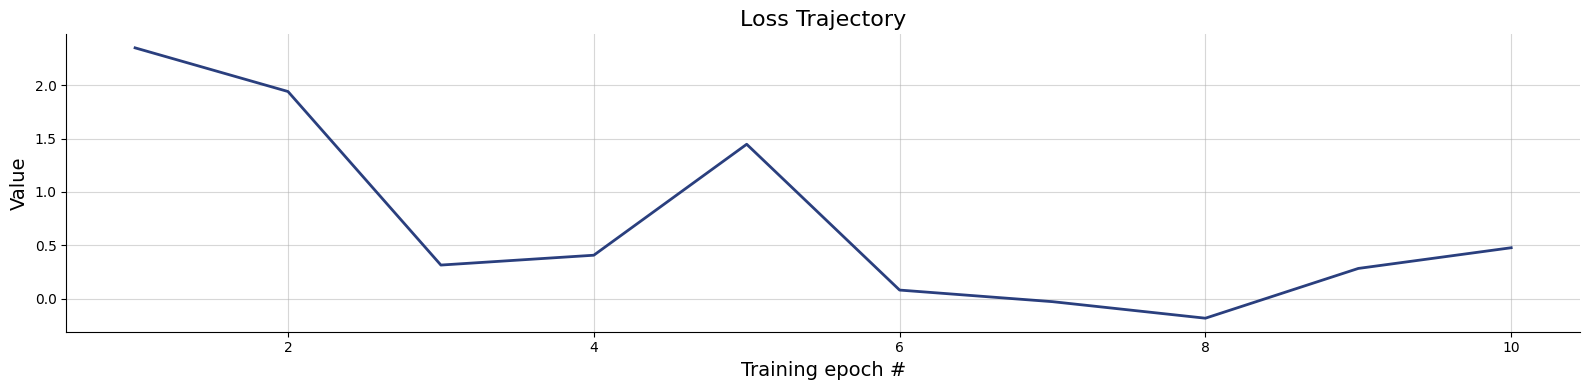

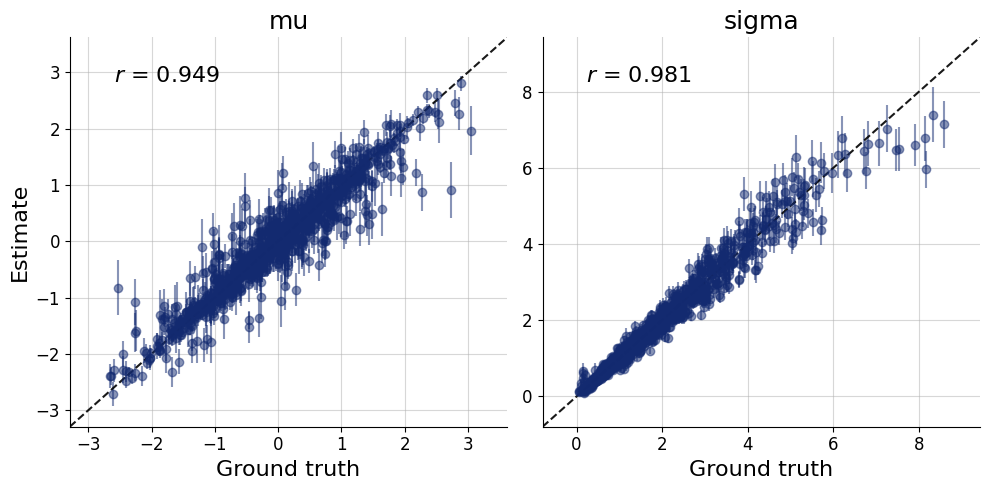

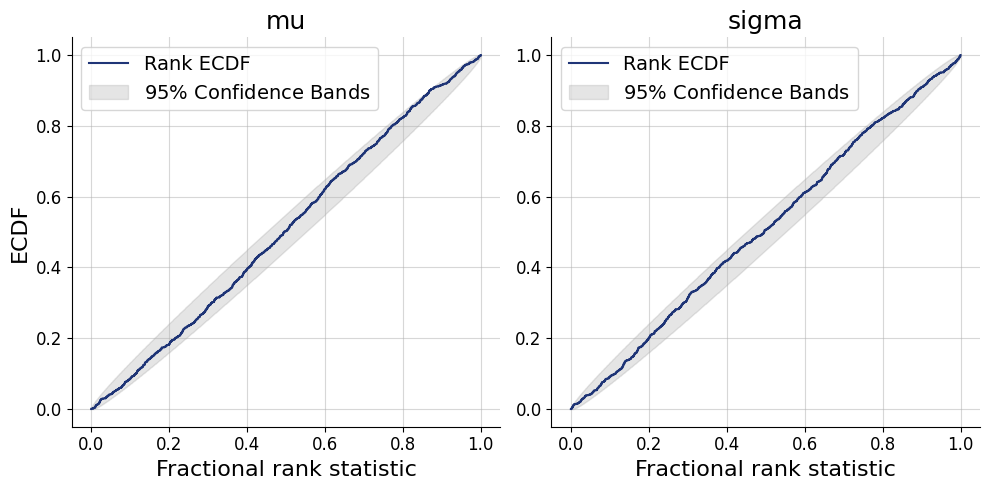

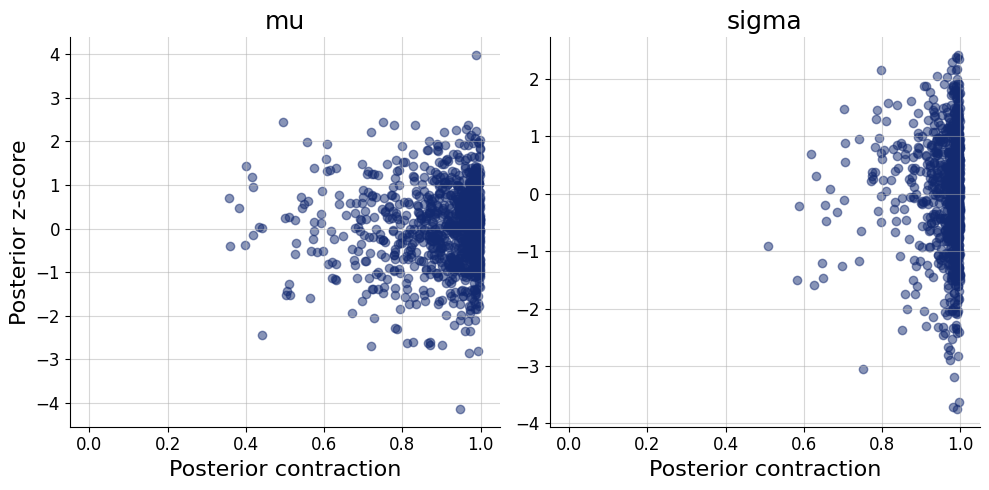

In [25]:
plots=workflow.plot_default_diagnostics(test_data=test_data)

## Inference

In [26]:
inference_data = dict(
    y = np.random.normal(loc=1, scale=0.6, size=(1, 50)),
    n = 50)

In [27]:
num_samples=2_000

In [28]:
posterior=workflow.sample(num_samples=num_samples, conditions=inference_data)
posterior=keras.tree.map_structure(np.squeeze, posterior)

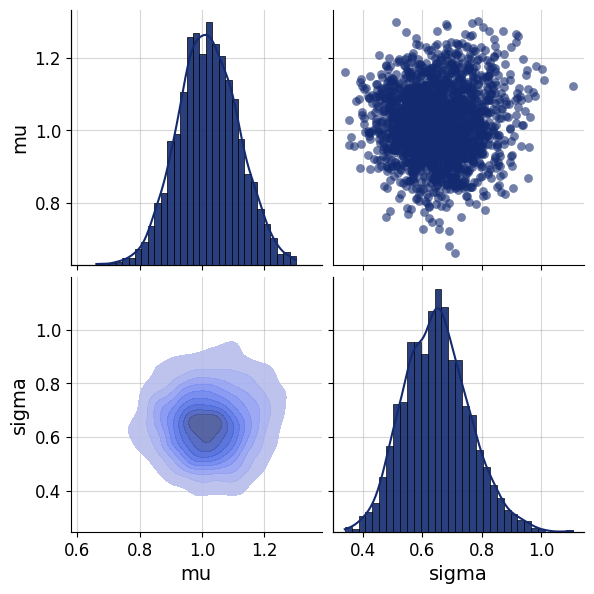

In [29]:
fig=bf.diagnostics.pairs_posterior(posterior)

In [30]:
posterior_predictives = simulator.sample(num_samples, n=50, **posterior)

In [31]:
summary(inference_data["y"])

{'mean': 1.001872416814181, 'sd': 0.6719715732550592}

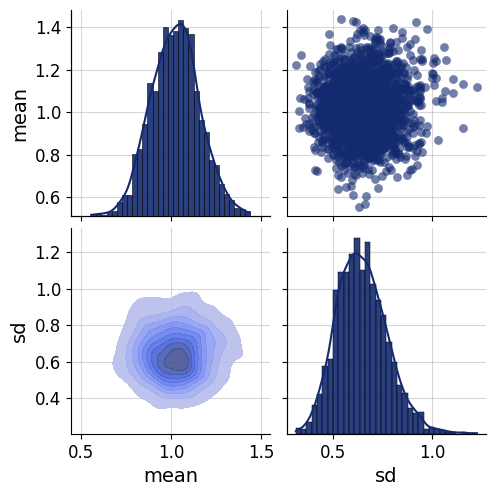

In [32]:
fig=bf.diagnostics.pairs_samples(posterior_predictives, variable_keys=["mean", "sd"])

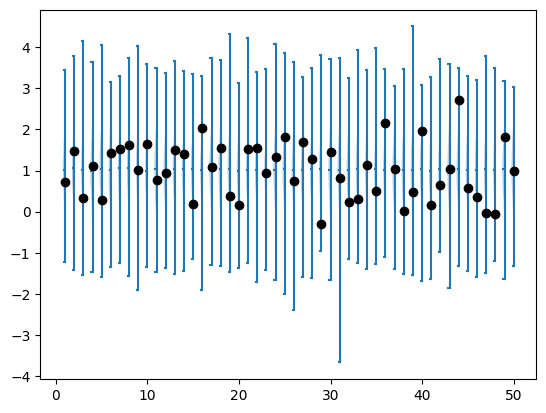

In [33]:
fig=plt.violinplot(posterior_predictives["y"], showmeans=True, side="low")
fig=plt.scatter(x=[i+1 for i in range(inference_data["n"])], y=inference_data["y"], c="black", zorder=100)

In [34]:
summaries_null=workflow.summary_network(workflow.simulate_adapted(1000)['summary_variables'])
summaries_ref=workflow.summary_network(workflow.simulate_adapted(500)['summary_variables'], training=False)

In [35]:
mmd_null = [
    bf.metrics.functional.maximum_mean_discrepancy(summaries_null, summaries_ref[i:i+1]).numpy() for i in range(500)
]

In [36]:
summaries_obs=workflow.summary_network(adapter(inference_data, strict=False)["summary_variables"])
mmd_obs=bf.metrics.functional.maximum_mean_discrepancy(summaries_null, summaries_obs)

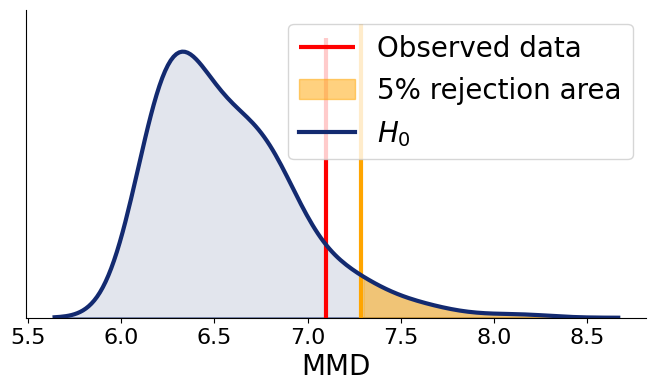

In [37]:
fig=bf.diagnostics.plots.mmd_hypothesis_test(mmd_null, mmd_obs)

# Exercises

1. Train a BayesFlow model that estimates the mean vector and a variance-covariance matrix of a 2D Gaussian.
2. Train a BayesFlow model that estimates parameter of any other distribution. You are free to choose which (some examples: Gamma, Negative binomial, Weibull,...)